<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, csc_matrix, hstack as shstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = '../data/raw'
PATH_TO_SUBMISSIONS = '../kaggle_submissions'

In [3]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [4]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [5]:
train_test_df = pd.concat([train_df, test_df], sort=False)

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [7]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [9]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [10]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [11]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [12]:
def sparsify_data(X, verbose=False):
    data = []
    row_ind = []
    col_ind = []
    max_site_ID = 0
    #split user site IDs into sessions and construct a sparse matrix of ID counts in a session
    for row_idx, row in enumerate(X.values):
        for site_ID in row:
            if site_ID > max_site_ID:
                max_site_ID = site_ID
            row_ind.append(row_idx)
            col_ind.append(site_ID) #site IDs can also serve as column indices, because they range from 0 to something
            data.append(1)
    X_sparse = csr_matrix((data, (row_ind, col_ind)), shape=(X.shape[0], max_site_ID+1), dtype=np.int64)
    return X_sparse[:, 1:] #exclude site ID 0

In [13]:
train_test_sparse = sparsify_data(train_test_df_sites)
X_train_sparse = train_test_sparse[:len(train_df)]
X_test_sparse = train_test_sparse[len(train_df):]
y = train_df['target'].values

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [14]:
print( ' '.join(map(str, X_train_sparse.shape + X_test_sparse.shape)) )

253561 48371 82797 48371


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [15]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [16]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [17]:
sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [18]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)[:, 1]

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [19]:
round(roc_auc_score(y_valid, logit_valid_pred_proba), 3)

0.934

**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [20]:
%%time
sgd_logit = SGDClassifier(loss='log', random_state=17).fit(X_train_sparse, y)
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)[:, 1]

Wall time: 317 ms


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [21]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [22]:
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_baseline.csv'))

---

## Улучшения

### Бейзлайн, подбор параметров с помощью GridSearchCV

In [23]:
def plot_validation_curves(param_values, grid_cv_results_, scale='linear'):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    if scale == 'linear':
        train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
        valid_line = plt.plot(param_values, valid_mu, '-', label='valid', color='red')
    if scale == 'log':
        train_line = plt.semilogx(param_values, train_mu, '-', label='train', color='green')
        valid_line = plt.semilogx(param_values, valid_mu, '-', label='valid', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [24]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Best params: alpha = 0.0001, score (roc auc) = 0.935876347755
Test score (roc auc) = 0.9338472867906151
Wall time: 7.13 s


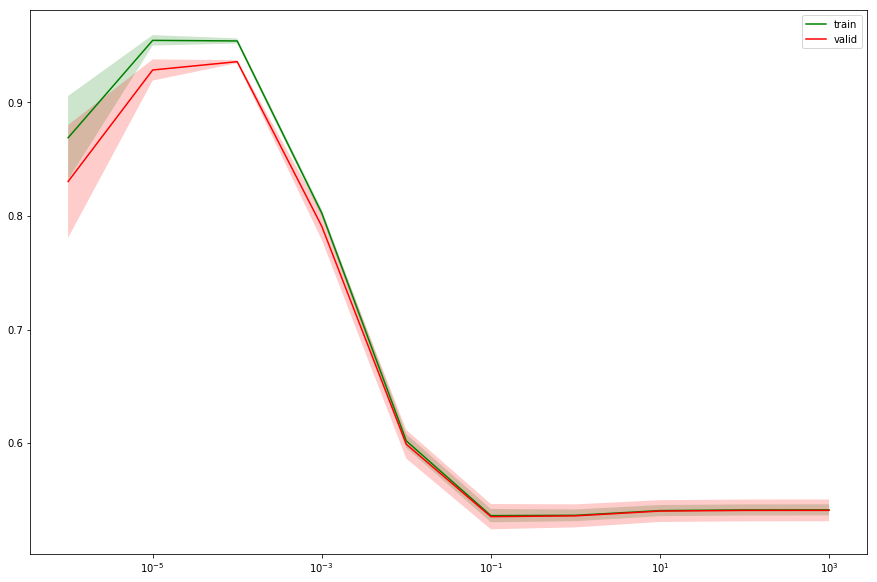

In [25]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf, n_jobs=-1)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Переберем параметры в более подходящем промежутке:*

Best params: alpha = 3.29034456231e-05, score (roc auc) = 0.948472710468
Test score (roc auc) = 0.9466227029434547
Wall time: 6.78 s


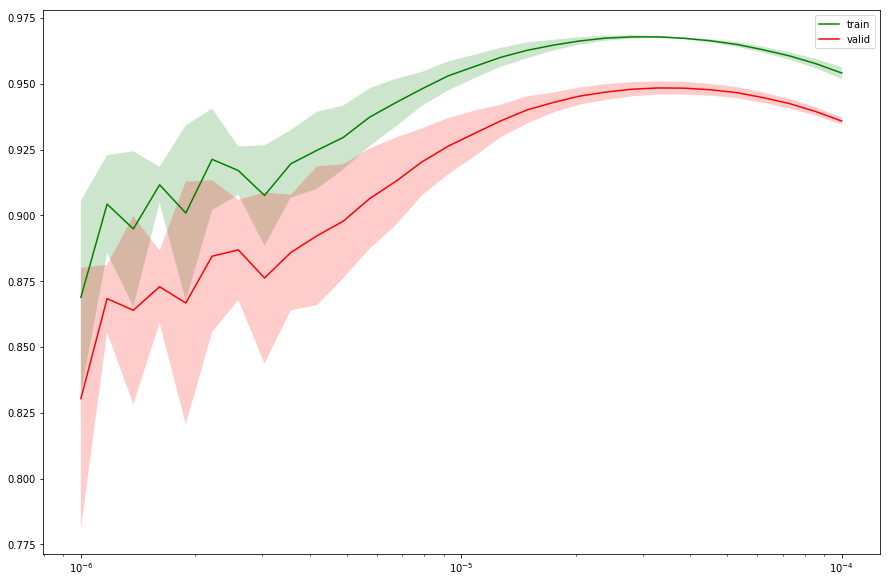

In [26]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, -4, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf, n_jobs=-1)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Результат улучшился. Сохраним его:*

In [27]:
logit_test_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch.csv'))

*Результат на публичном лидерборде на kaggle: 0.90909. Немного хуже бейзлайна без подбора параметров, что несколько странно.*

### SGDClassifier + фичи с недели 3

*С недели 3 взяты лишь некоторые фичи, из них выбраны только те, с которыми качество на обучающей выборке заметно выросло (остальные закомменчены).*

In [28]:
# OneHotEncoder converts integer categories to float, and it affects get_feature_names method (output is like 'hour_7.0')
# this wrapper class is to fix that behaviour
class OneHotEncoderFixed(OneHotEncoder):
    def fit_transform(self, X, y=None):
        X_out = super(OneHotEncoder, self).fit_transform(X, y)
        self.categories_ = [cat.astype(X.dtype) for cat in self.categories_]
        return X_out

In [1]:
def get_session_timespan_log(row):
    row_ne = row[~np.isnat(row)]
    result = int((row_ne[-1]-row_ne[0]) / np.timedelta64(1, 's'))
    return np.log(result) if result > 0 else 0

def count_unique_sites(row):
    row_unique = np.unique(row)
    return len(row_unique[row_unique != 0]) #0 is not a valid site ID

def add_features(X_sites, X_times):
    X = sparsify_data(X_sites)
    site_columns = [col for col in X_sites.columns if col.startswith('site')]
    
    features = []
    cat_features = []
    
    # session_timespan_log
    #features.append( X_times.apply(get_session_timespan_log, raw=True, axis=1) )
    
    #start_hour (one-hot encoded) 
    start_hour = X_times['time1'].dt.hour
    start_hour_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( start_hour_encoder.fit_transform(start_hour[:, np.newaxis]) )
    
    # timeofday (one-hot encoded)
    timeofday = np.mod(start_hour + 2, 24) // 6
    timeofday_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( timeofday_encoder.fit_transform(timeofday[:, np.newaxis]) )
    
    # dayofweek (one-hot encoded)
    dayofweek = X_times['time1'].dt.dayofweek
    dayofweek_encoder = OneHotEncoderFixed(sparse=True, dtype=np.int16)
    cat_features.append( dayofweek_encoder.fit_transform(dayofweek[:, np.newaxis]) )
    
    # weekend
    features.append( (dayofweek >= 5).astype(int) )
    
    # #unique_sites
    #features.append( X_sites[site_columns].apply(count_unique_sites, raw=True, axis=1) )
    
    features = [np.array(features).transpose()] if features != [] else []
    X = csr_matrix(shstack([X] + features + cat_features))
    
    return X

In [30]:
%%time
train_test_df_times = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(np.datetime64('NaT')).astype(np.datetime64)
train_test_df_with_features = add_features(train_test_df_sites, train_test_df_times)

X_train_sparse = train_test_df_with_features[:len(train_df)]
X_test_sparse = train_test_df_with_features[len(train_df):]
y = train_df['target'].values

train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

Wall time: 4.96 s


In [31]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

Best params: alpha = 1e-05, score (roc auc) = 0.978380033612
Test score (roc auc) = 0.9785046971213142
Wall time: 7.4 s


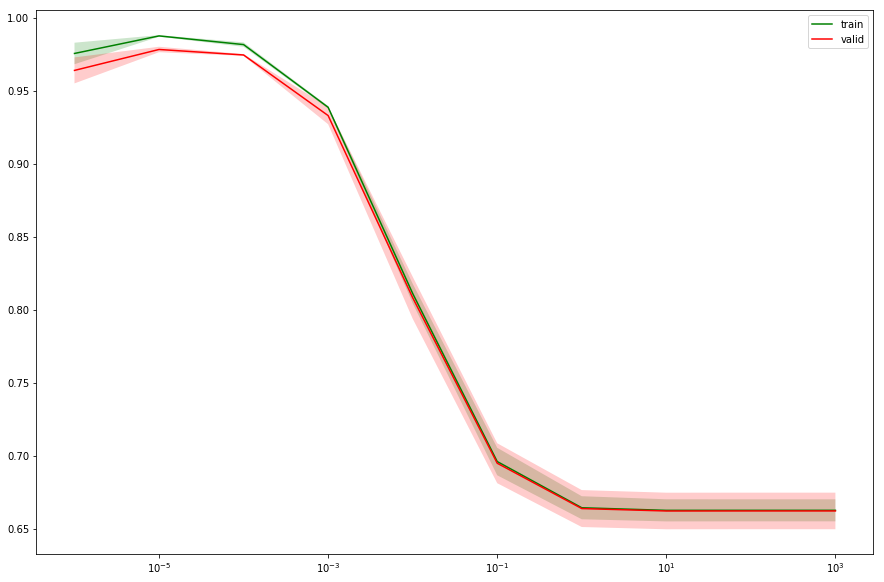

In [32]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, 3, 10)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Переберем параметры в более подходящем промежутке:*

Best params: alpha = 2.39502661999e-05, score (roc auc) = 0.980362784964
Test score (roc auc) = 0.9792589596449324
Wall time: 20.8 s


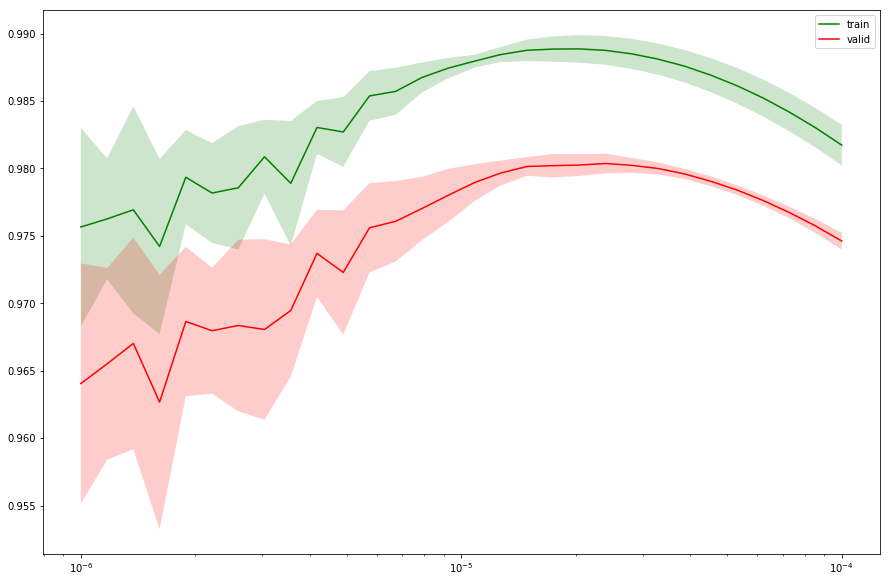

In [33]:
%%time
sgd_logit_params = {'alpha': np.logspace(-6, -4, 30)}

sgd_logit = SGDClassifier(loss='log', random_state=17)
sgd_logit_grid_searcher = GridSearchCV(sgd_logit, param_grid=sgd_logit_params, scoring='roc_auc', cv=skf)
sgd_logit_grid_searcher.fit(X_train, y_train)

sgd_logit_best_alpha = sgd_logit_grid_searcher.best_params_['alpha']
sgd_logit_best_score = sgd_logit_grid_searcher.best_score_
print('Best params: alpha = {}, score (roc auc) = {}'.format(sgd_logit_best_alpha, sgd_logit_best_score))

logit_valid_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_valid)[:, 1]
print('Test score (roc auc) =', roc_auc_score(y_valid, logit_valid_pred_proba))

plt.figure(figsize=(15, 10))
plot_validation_curves(sgd_logit_params['alpha'], sgd_logit_grid_searcher.cv_results_, scale='log')

*Результат улучшился. Сохраним его:*

In [34]:
logit_test_pred_proba = sgd_logit_grid_searcher.best_estimator_.predict_proba(X_test_sparse)[:, 1]
write_to_submission_file(logit_test_pred_proba, os.path.join(PATH_TO_SUBMISSIONS, 'SGDClassifier_GridSearch_4feat.csv'))

*Результат на публичном лидерборде на kaggle: 0.94186. Побиты оба требуемых бенчмарка.*

### Бенчмарки с публичного лидерборда на kaggle

* `sgd_logit_benchmark.csv` - 0.91273
* `Logit +3 features` - 0.92784

**Название команды на kaggle:**

**\[YDF & MIPT\] Coursera_Alex Galak**

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.